In [4]:
# Import required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Libraries imported successfully!
Pandas version: 2.2.3
Matplotlib version: 3.10.1


In [121]:
raw_data = pd.read_excel("../data/sampled_df_with_generated_questions.xlsx")

In [87]:
# Define the path to evaluator outputs
output_path = Path("../error_checking/automated_outputs/evaluator_outputs")
print(f"Looking for files in: {output_path.absolute()}")

# Check if directory exists
if not output_path.exists():
    print(f"ERROR: Directory {output_path} does not exist!")
    print("Please check the path and make sure the evaluator outputs are available.")
else:
    print(f"Directory exists: {output_path.exists()}")
    
    # List files in directory
    files = list(output_path.glob("evaluator_row_*.json"))
    print(f"Found {len(files)} evaluator output files")
    
    if len(files) > 0:
        print(f"Sample files: {[f.name for f in files[:5]]}")

Looking for files in: /Users/wenyuanchen/Desktop/Stanford/HealthRex/CDSS_aim4/scripts/antibiotic-susceptibility/sql/queries/aim_4/AIM4/Embedding_Pilot_Exp/notebook/../error_checking/automated_outputs/evaluator_outputs
Directory exists: True
Found 100 evaluator output files
Sample files: ['evaluator_row_0001.json', 'evaluator_row_0056.json', 'evaluator_row_0040.json', 'evaluator_row_0017.json', 'evaluator_row_0083.json']


In [88]:
import re
import json

# Load all JSON files
json_files = glob.glob(str(output_path / "evaluator_row_*.json"))
print(f"Found {len(json_files)} evaluator output files")

# Process each file
data = []
errors_loading = []

def fix_json_string(json_str):
    """Fix common JSON string issues"""
    # Remove any trailing commas before closing braces/brackets
    json_str = re.sub(r',(\s*[}\]])', r'\1', json_str)
    
    # Fix unescaped quotes in reason_for_error_in_physician_response
    # Look for the problematic field and escape quotes within it
    pattern = r'("reason_for_error_in_physician_response":\s*")([^"]*(?:[^"]*"[^"]*)*?)(")'
    
    def escape_quotes(match):
        prefix = match.group(1)
        content = match.group(2)
        suffix = match.group(3)
        # Escape quotes in the content
        content = content.replace('"', '\\"')
        return prefix + content + suffix
    
    json_str = re.sub(pattern, escape_quotes, json_str)
    
    return json_str

for file_path in sorted(json_files):
    try:
        with open(file_path, 'r') as f:
            file_data = json.load(f)
            
        # Get the evaluator_output string
        evaluator_output_str = file_data.get('evaluator_output', '{}')
        
        # Try to fix common JSON issues
        try:
            evaluator_output = json.loads(evaluator_output_str)
        except json.JSONDecodeError as e:
            print(f"Attempting to fix JSON in {Path(file_path).name}...")
            # Try to fix the JSON string
            fixed_json_str = fix_json_string(evaluator_output_str)
            try:
                evaluator_output = json.loads(fixed_json_str)
                print(f"  Successfully fixed JSON in {Path(file_path).name}")
            except json.JSONDecodeError as e2:
                print(f"  Failed to fix JSON in {Path(file_path).name}: {e2}")
                # Try a more aggressive approach - extract what we can
                evaluator_output = {}
                try:
                    # Try to extract basic fields using regex
                    subject_match = re.search(r'"subject":\s*"([^"]*)"', evaluator_output_str)
                    type_match = re.search(r'"type":\s*"([^"]*)"', evaluator_output_str)
                    
                    if subject_match and type_match:
                        evaluator_output = {
                            'message_categorization': {
                                'subject': subject_match.group(1),
                                'type': type_match.group(1),
                                'reasoning': ''
                            },
                            'response_evaluation': {},
                            'errors_identified': []
                        }
                        print(f"  Extracted basic info from {Path(file_path).name}")
                    else:
                        raise e2
                except:
                    print(f"  Could not extract any data from {Path(file_path).name}")
                    errors_loading.append(f"Failed to parse {file_path}: {e}")
                    continue
        
        # Extract row number from filename
        row_num = Path(file_path).stem.split('_')[-1]
        
        # Flatten the data structure
        flat_data = {
            'row_number': row_num,
            'file_path': file_path,
            'subject': evaluator_output.get('message_categorization', {}).get('subject', ''),
            'type': evaluator_output.get('message_categorization', {}).get('type', ''),
            'reasoning': evaluator_output.get('message_categorization', {}).get('reasoning', ''),
        }
        
        # Extract evaluation scores
        response_eval = evaluator_output.get('response_evaluation', {})
        for metric, details in response_eval.items():
            if isinstance(details, dict):
                flat_data[f'{metric}_score'] = details.get('score', '')
                flat_data[f'{metric}_reasoning'] = details.get('reasoning', '')
        
        # Extract error information - ALL FIELDS
        errors = evaluator_output.get('errors_identified', [])
        flat_data['num_errors'] = len(errors)
        flat_data['error_types'] = [error.get('type', '') for error in errors]
        flat_data['error_severities'] = [error.get('severity', '') for error in errors]
        flat_data['error_descriptions'] = [error.get('description', '') for error in errors]
        flat_data['error_text_excerpts'] = [error.get('text_excerpt', '') for error in errors]
        flat_data['error_in_physician_response'] = [error.get('error_in_physician_response', '') for error in errors]
        flat_data['reason_for_error_in_physician_response'] = [error.get('reason_for_error_in_physician_response', '') for error in errors]
        
        data.append(flat_data)
        
    except Exception as e:
        error_msg = f"Error loading {file_path}: {e}"
        print(error_msg)
        errors_loading.append(error_msg)

# Convert to DataFrame
df = pd.DataFrame(data)
print(f"\nSuccessfully loaded {len(df)} records")
print(f"Failed to load {len(errors_loading)} files")

if len(df) > 0:
    print("\nFirst few records:")
    display(df.head())
    
    # Show the columns we have
    print("\nColumns in the dataframe:")
    print(df.columns.tolist())
    
    # Show which files had issues
    if errors_loading:
        print("\nFiles with loading issues:")
        for error in errors_loading:
            print(f"  {error}")

Found 100 evaluator output files

Successfully loaded 100 records
Failed to load 0 files

First few records:


,row_number,file_path,subject,type,reasoning,clinical_accuracy_score,clinical_accuracy_reasoning,urgency_recognition_score,urgency_recognition_reasoning,professional_consultation_guidance_score,professional_consultation_guidance_reasoning,sensitivity_clarity_score,sensitivity_clarity_reasoning,num_errors,error_types,error_severities,error_descriptions,error_text_excerpts,error_in_physician_response,reason_for_error_in_physician_response
0,0000,../error_checking/automated_outputs/evaluator_...,Non-urgent Medical Question,Clinical Advice Request,The patient's message describes a clinical con...,9,The response correctly acknowledges the concer...,8,The response recognizes the 'rapid' progressio...,9,The guidance to expect a referral and to utili...,10,"The response is empathetic, clear, and support...",1,[Clinical Error],[2],[The response does not specify the location/pr...,"[Given the rapid changes you're experiencing, ...",[No],[I've ordered this for you to be done at the H...
1,0001,../error_checking/automated_outputs/evaluator_...,Ordered Test Question,Clinical Advice Request,The patient is explicitly asking for clinical ...,7,The guidance on stopping metformin the day of ...,8,The response adequately recognizes the patient...,6,The response gives some guidance but does not ...,9,"The tone is warm, clear, and supportive, with ...",1,[Clinical Error],[3],[Did not advise the patient to contact the off...,[You can continue taking your Ozempic as usual...,[No],[Please contact the office at 510-521-2300 as ...
2,0002,../error_checking/automated_outputs/evaluator_...,Prescription Question,Medication Request,The patient requests prescription refills for ...,7,The LLM accurately approves omeprazole and giv...,8,"No acute clinical urgency is recognized, which...",7,The response gives proper process guidance for...,9,"Clear, polite, and supportive language is used...",1,[Clinical Error],[3],[The response assumes refills are available fo...,"[Regarding the 7.5 mg buspirone, it seems you ...",[No],[Prescription busPIRone 7.5 mg tablet was sent...
3,0003,../error_checking/automated_outputs/evaluator_...,Non-urgent Medical Question,Clinical Advice Request,The patient is requesting clinical advice on t...,6,The response suggests an in-person visit is be...,7,The response identifies the time-sensitive nat...,5,"The guidance is generic and incomplete, sugges...",9,"The response is warm, clear, and polite in ton...",3,"[Clinical Error, Clinical Error, Non-Clinical ...","[3, 3, 2]",[Incorrectly implies that all travel vaccinati...,[For travel-related vaccinations and medicatio...,"[No, No, No]",[our facility does not operate as a travel vac...
4,0004,../error_checking/automated_outputs/evaluator_...,Prescription Question,Medication Request,The patient specifically requests a renewal an...,0,"The LLM-generated response is 'Unknown', which...",0,"The LLM-generated response is 'Unknown', which...",0,"The LLM-generated response is 'Unknown', which...",0,The LLM-generated response 'Unknown' is unempa...,1,[Non-Clinical Error],[3],[No response provided to the patient's request...,[Unknown],[No],[The physician response directly addresses the...



Columns in the dataframe:
['row_number', 'file_path', 'subject', 'type', 'reasoning', 'clinical_accuracy_score', 'clinical_accuracy_reasoning', 'urgency_recognition_score', 'urgency_recognition_reasoning', 'professional_consultation_guidance_score', 'professional_consultation_guidance_reasoning', 'sensitivity_clarity_score', 'sensitivity_clarity_reasoning', 'num_errors', 'error_types', 'error_severities', 'error_descriptions', 'error_text_excerpts', 'error_in_physician_response', 'reason_for_error_in_physician_response']


In [99]:
df.columns

Index(['row_number', 'file_path', 'subject', 'type', 'reasoning',
       'clinical_accuracy_score', 'clinical_accuracy_reasoning',
       'urgency_recognition_score', 'urgency_recognition_reasoning',
       'professional_consultation_guidance_score',
       'professional_consultation_guidance_reasoning',
       'sensitivity_clarity_score', 'sensitivity_clarity_reasoning',
       'num_errors', 'error_types', 'error_severities', 'error_descriptions',
       'error_text_excerpts', 'error_in_physician_response',
       'reason_for_error_in_physician_response'],
      dtype='object')

In [101]:
# Convert all columns containing integers to int type
# Identify columns that should be integers
integer_columns = [
    'clinical_accuracy_score',
    'urgency_recognition_score', 
    'professional_consultation_guidance_score',
    'sensitivity_clarity_score',
    'num_errors'
]

# Convert these columns to int type, handling any non-numeric values
for col in integer_columns:
    if col in df.columns:
        # Convert to numeric, coercing errors to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Fill NaN values with 0 or another appropriate default
        df[col] = df[col].fillna(0).astype(int)

# Also convert error_severities from list of strings to list of integers
def convert_severities_to_int(severities_list):
    """Convert list of string severities to list of integers"""
    if isinstance(severities_list, list):
        return [int(sev) if str(sev).isdigit() else 0 for sev in severities_list]
    return []

# Apply the conversion to error_severities column
df['error_severities'] = df['error_severities'].apply(convert_severities_to_int)

print("Data types after conversion:")
print(df[integer_columns].dtypes)
print("\nSample of converted data:")
df[integer_columns].head()

Data types after conversion:
clinical_accuracy_score                     int64
urgency_recognition_score                   int64
professional_consultation_guidance_score    int64
sensitivity_clarity_score                   int64
num_errors                                  int64
dtype: object

Sample of converted data:


,clinical_accuracy_score,urgency_recognition_score,professional_consultation_guidance_score,sensitivity_clarity_score,num_errors
0,9,8,9,10,1
1,7,8,6,9,1
2,7,8,7,9,1
3,6,7,5,9,3
4,0,0,0,0,1


In [157]:
df["has_LLM_response"] = df["error_text_excerpts"].apply(lambda x: "Unknown" not in x)


In [162]:
no_LLM_response_df = df[df["error_text_excerpts"].apply(lambda x: "Unknown" in x)]

In [161]:
with_LLM_response_df =  df[~df["error_text_excerpts"].apply(lambda x: "Unknown" in x)]

In [104]:
df["type"].value_counts()

type
Medication Request         27
Clinical Advice Request    24
Test Result Inquiry        18
Referral Request           13
Administrative Request     10
Appointment Request         7
General Inquiry             1
Name: count, dtype: int64

In [105]:
no_LLM_response_df["type"].value_counts()

type
Medication Request        4
Administrative Request    2
Name: count, dtype: int64

In [106]:
with_LLM_response_df["type"].value_counts()

type
Clinical Advice Request    24
Medication Request         23
Test Result Inquiry        18
Referral Request           13
Administrative Request      8
Appointment Request         7
General Inquiry             1
Name: count, dtype: int64

In [140]:
# Add 'has_error' column: any errors present?
df['has_error'] = df['num_errors'].apply(lambda x: x > 0)

# Error rate
error_rate = df['has_error'].mean()

# Count by error type (flattened)
from collections import Counter

error_type_counts = Counter([et for row in df['error_types'] for et in row])
error_type_counts = pd.Series(error_type_counts)

# Severity distribution (flattened)
severity_counts = Counter([sev for row in df['error_severities'] for sev in row])
severity_counts = pd.Series(severity_counts).sort_index()

# Average severity per message (where applicable)
# Fix: Convert string severity values to integers before calculating mean
df['avg_error_severity'] = df['error_severities'].apply(
    lambda x: np.mean([int(sev) for sev in x]) if x else 0
)
avg_severity = df['avg_error_severity'].mean()

print(f'Error rate: {error_rate:.2%}')
print('Error type counts:\n', error_type_counts)
print('Severity distribution:\n', severity_counts)
print(f'Average severity (overall): {avg_severity:.2f}')


Error rate: 89.00%
Error type counts:
 Clinical Error        74
Non-Clinical Error    58
dtype: int64
Severity distribution:
 1     6
2    60
3    56
4     6
5     4
dtype: int64
Average severity (overall): 2.31


In [141]:
# Add 'has_error' column: any errors present?
with_LLM_response_df['has_error'] = with_LLM_response_df['num_errors'].apply(lambda x: x > 0)

# Error rate
error_rate = with_LLM_response_df['has_error'].mean()

# Count by error type (flattened)
from collections import Counter

error_type_counts = Counter([et for row in with_LLM_response_df['error_types'] for et in row])
error_type_counts = pd.Series(error_type_counts)

# Severity distribution (flattened)
severity_counts = Counter([sev for row in with_LLM_response_df['error_severities'] for sev in row])
severity_counts = pd.Series(severity_counts).sort_index()

# Average severity per message (where applicable)
# Fix: Convert string severity values to integers before calculating mean
with_LLM_response_df['avg_error_severity'] = with_LLM_response_df['error_severities'].apply(
    lambda x: np.mean([int(sev) for sev in x]) if x else np.nan
)
avg_severity = with_LLM_response_df['avg_error_severity'].mean()

print(f'Error rate: {error_rate:.2%}')
print('Error type counts:\n', error_type_counts)
print('Severity distribution:\n', severity_counts)
print(f'Average severity (overall): {avg_severity:.2f}')


Error rate: 88.04%
Error type counts:
 Clinical Error        71
Non-Clinical Error    49
dtype: int64
Severity distribution:
 1     6
2    59
3    50
4     5
dtype: int64
Average severity (overall): 2.49


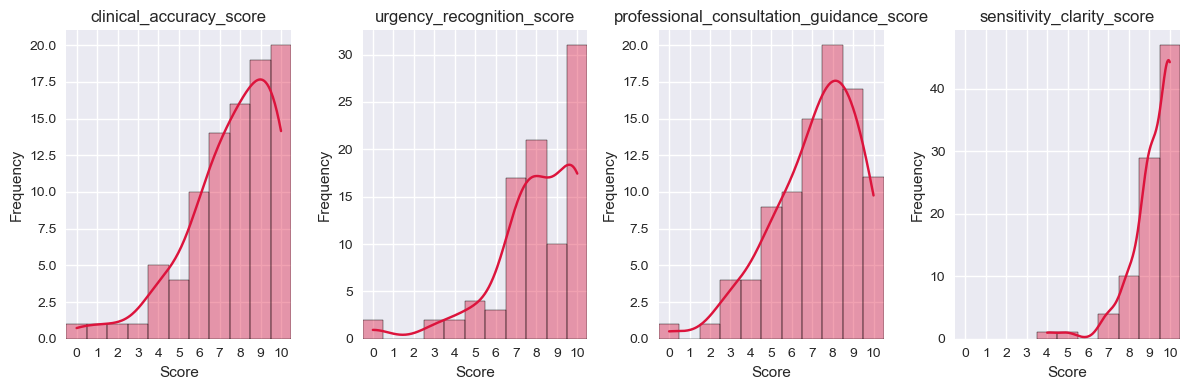

In [148]:
score_columns = [
    'clinical_accuracy_score', 
    'urgency_recognition_score', 
    'professional_consultation_guidance_score',
    'sensitivity_clarity_score'
]

plt.figure(figsize=(12, 4))
for i, col in enumerate(score_columns):
    plt.subplot(1, len(score_columns), i+1)
    data = with_LLM_response_df[col].dropna().astype(int)  # Ensure integer type for scores
    # Set bins to cover each integer from 0 to 10
    bins = range(0, 12)  # 0-11, so 0-10 are centers
    sns.histplot(data, bins=bins, discrete=True, kde=True, color='crimson', alpha=0.4)
    plt.title(col)
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.xticks(range(0, 11))  # Show 0-10 in order
    plt.xlim(-0.5, 10.5)      # Center bars on integer ticks

plt.tight_layout()
plt.show()

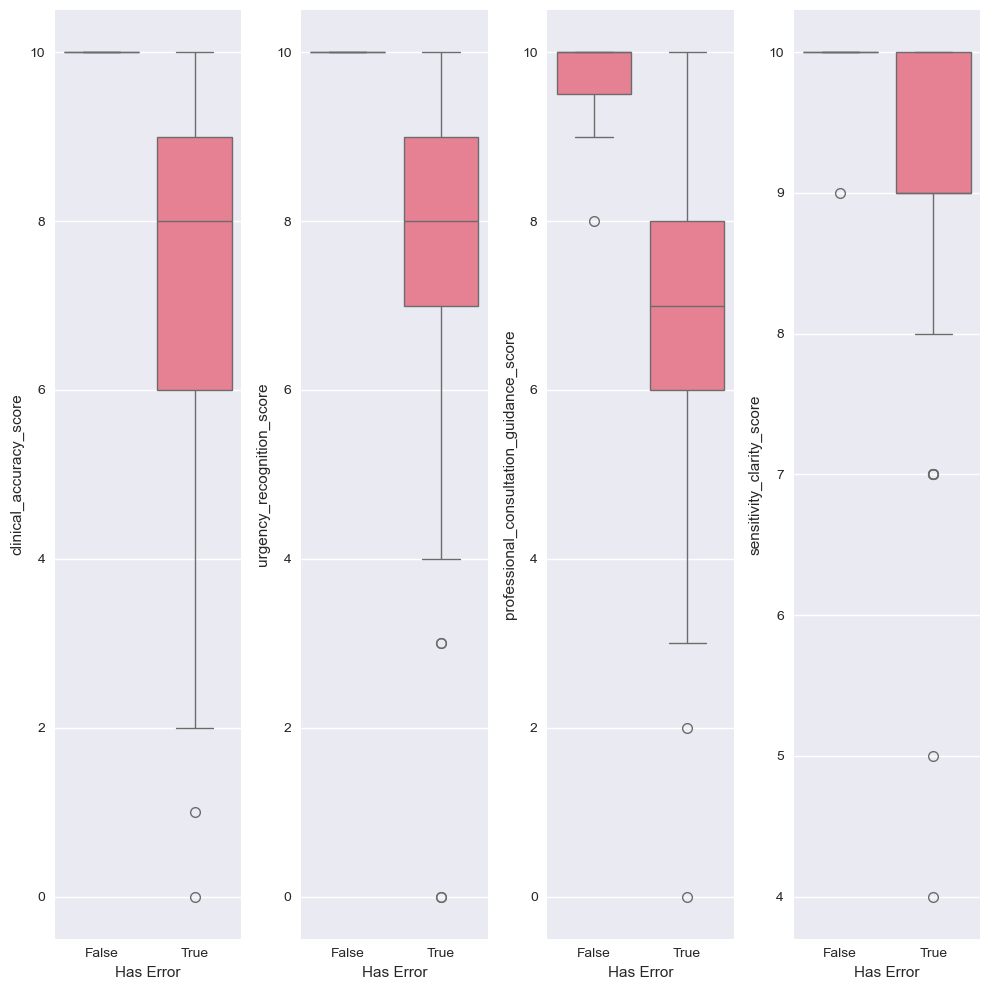

In [149]:
plt.figure(figsize=(10,10))
for i, col in enumerate(score_columns):
    plt.subplot(1, len(score_columns), i+1)
    sns.boxplot(x=with_LLM_response_df['has_error'], y=with_LLM_response_df[col])
    # plt.title(col + " by error")
    plt.xlabel('Has Error')
plt.tight_layout()
plt.show()


In [150]:
# Crosstab: message type vs error type frequency
ct_error_type = pd.DataFrame([
    {
        'type': row['type'],
        **Counter(row['error_types'])
    }
    for _, row in with_LLM_response_df.iterrows()
])

# Group by message type
type_error_freq = ct_error_type.groupby('type').sum()

# Show (transpose for readability)
type_error_freq.T

# Average error severity by type
avg_severity_by_type = with_LLM_response_df.groupby('type')['avg_error_severity'].mean()
avg_scores_by_type = with_LLM_response_df.groupby('type')[score_columns].mean()


Avg error severity by message type:
 type
Administrative Request     2.250000
Appointment Request        2.166667
Clinical Advice Request    2.076389
General Inquiry            0.000000
Medication Request         2.142857
Referral Request           2.602564
Test Result Inquiry        2.212963
Name: avg_error_severity, dtype: float64
Avg scores by type:
                          clinical_accuracy_score  urgency_recognition_score  \
type                                                                          
Administrative Request                  7.750000                   7.875000   
Appointment Request                     8.142857                   8.857143   
Clinical Advice Request                 7.750000                   7.875000   
General Inquiry                        10.000000                  10.000000   
Medication Request                      7.761905                   7.952381   
Referral Request                        6.846154                   6.846154   
Test Result 

In [151]:
avg_severity_by_type

type
Administrative Request     2.250000
Appointment Request        2.166667
Clinical Advice Request    2.076389
General Inquiry            0.000000
Medication Request         2.142857
Referral Request           2.602564
Test Result Inquiry        2.212963
Name: avg_error_severity, dtype: float64

In [136]:
avg_scores_by_type

,clinical_accuracy_score,urgency_recognition_score,professional_consultation_guidance_score,sensitivity_clarity_score
type,,,,
Administrative Request,7.750000,7.875000,7.000000,9.125000
Appointment Request,8.142857,8.857143,7.000000,9.428571
Clinical Advice Request,7.750000,7.875000,7.583333,9.250000
General Inquiry,10.000000,10.000000,10.000000,10.000000
Medication Request,7.761905,7.952381,7.000000,9.380952
Referral Request,6.846154,6.846154,6.076923,8.230769
Test Result Inquiry,7.555556,8.833333,7.777778,9.611111


## 1. How often does the LLM make mistakes?

                     0
N                100.0
N with error      89.0
N without error   11.0
% with error      89.0
% without error   11.0


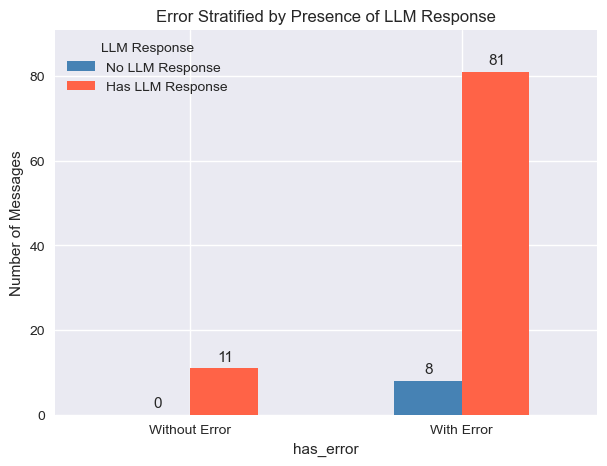

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Calculate error rate stats
total_msgs = len(df)
n_with_error = df['has_error'].sum()
n_without_error = total_msgs - n_with_error
pct_with_error = n_with_error / total_msgs * 100
pct_without_error = 100 - pct_with_error

# 2. Print summary table
summary = pd.DataFrame({
    'N': [total_msgs],
    'N with error': [n_with_error],
    'N without error': [n_without_error],
    '% with error': [pct_with_error],
    '% without error': [pct_without_error]
})
print(summary.T)

# # 3. Bar plot: With vs Without Error
plt.figure(figsize=(5,4))
# Group and count: error x has_LLM_response
counts = df.groupby(['has_error', 'has_LLM_response']).size().unstack(fill_value=0)

# Plot
counts.plot(kind='bar', color=['steelblue', 'tomato'], figsize=(7,5))
plt.xticks([0,1], ['Without Error', 'With Error'], rotation=0)
plt.ylabel('Number of Messages')
plt.title('Error Stratified by Presence of LLM Response')
plt.legend(['No LLM Response', 'Has LLM Response'], title='LLM Response')
for i, total in enumerate(counts.values):
    for j, val in enumerate(total):
        plt.text(i-0.12+j*0.25, val+1, str(val), ha='center', va='bottom', fontsize=11)
plt.ylim(0, counts.values.max() + 10)
plt.show()

                         0
N                92.000000
N with error     81.000000
N without error  11.000000
% with error     88.043478
% without error  11.956522


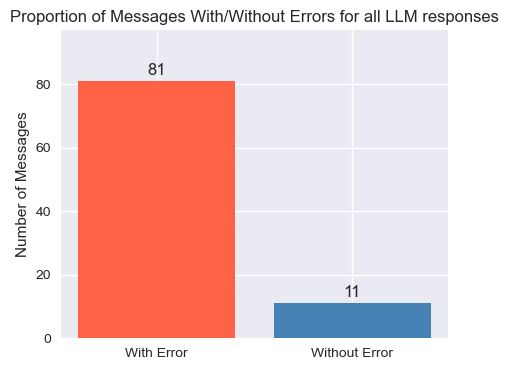

In [166]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Calculate error rate stats
total_msgs = len(with_LLM_response_df)
n_with_error = with_LLM_response_df['has_error'].sum()
n_without_error = total_msgs - n_with_error
pct_with_error = n_with_error / total_msgs * 100
pct_without_error = 100 - pct_with_error

# 2. Print summary table
summary = pd.DataFrame({
    'N': [total_msgs],
    'N with error': [n_with_error],
    'N without error': [n_without_error],
    '% with error': [pct_with_error],
    '% without error': [pct_without_error]
})
print(summary.T)

# 3. Bar plot: With vs Without Error
plt.figure(figsize=(5,4))
bars = plt.bar(['With Error', 'Without Error'], [n_with_error, n_without_error], color=['tomato', 'steelblue'])
plt.ylabel('Number of Messages')
plt.title('Proportion of Messages With/Without Errors for all LLM responses')
plt.ylim(0, total_msgs + 5)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, int(yval), ha='center', va='bottom', fontsize=12)
plt.show()

## 2. Are most errors minor, or are there a worrying number of serious ones?

In [181]:
import pandas as pd
from collections import Counter

# Flatten all severities into a single list
all_severities = [sev for row in with_LLM_response_df['error_severities'] for sev in row]

# Count by severity
severity_counts = pd.Series(Counter(all_severities)).sort_index()
severity_percent = (severity_counts / severity_counts.sum()) * 100

# Display table
severity_table = pd.DataFrame({
    'Count': severity_counts,
    'Percent': severity_percent.round(1)
})
print(severity_table)


   Count  Percent
1      6      5.0
2     59     49.2
3     50     41.7
4      5      4.2


In [182]:
n_severe = sum(sev >= 4 for sev in all_severities)
pct_severe = n_severe / len(all_severities) * 100
print(f"Number of major/severe errors (severity ≥4): {n_severe} ({pct_severe:.1f}%)")


Number of major/severe errors (severity ≥4): 5 (4.2%)


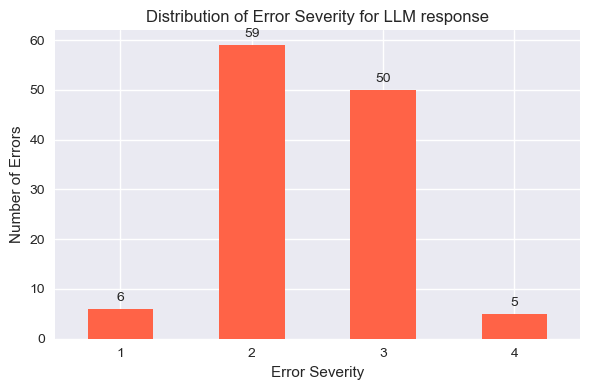

In [183]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
severity_counts.plot(kind='bar', color='tomato')
plt.xlabel('Error Severity')
plt.ylabel('Number of Errors')
plt.title('Distribution of Error Severity for LLM response')
plt.xticks(rotation=0)
for idx, val in enumerate(severity_counts):
    plt.text(idx, val+1, int(val), ha='center', va='bottom')
plt.tight_layout()
plt.show()

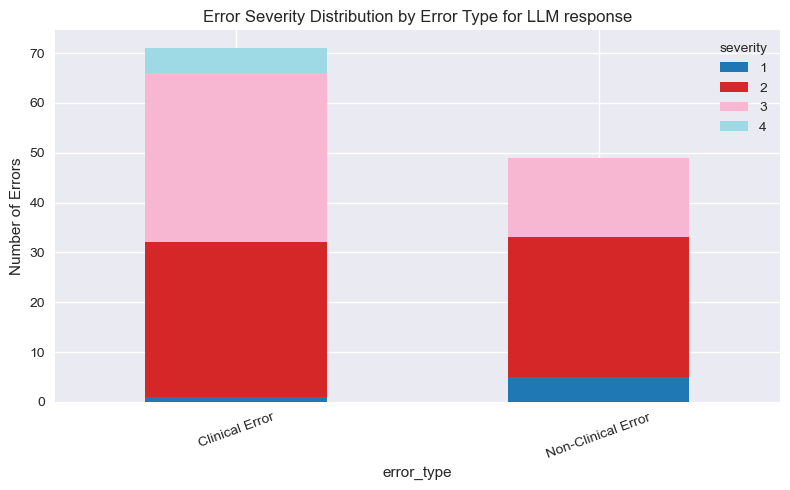

In [184]:
# Prepare a DataFrame for severity x error_type
error_type_sev = []
for _, row in with_LLM_response_df.iterrows():
    for et, sev in zip(row['error_types'], row['error_severities']):
        error_type_sev.append((et, sev))

err_df = pd.DataFrame(error_type_sev, columns=['error_type', 'severity'])
pivot = pd.crosstab(err_df['error_type'], err_df['severity']).sort_index(axis=1)

pivot.plot(kind='bar', stacked=True, figsize=(8,5), colormap='tab20')
plt.ylabel("Number of Errors")
plt.title("Error Severity Distribution by Error Type for LLM response")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


For no LLM response

In [185]:
import pandas as pd
from collections import Counter

# Flatten all severities into a single list
all_severities = [sev for row in no_LLM_response_df['error_severities'] for sev in row]

# Count by severity
severity_counts = pd.Series(Counter(all_severities)).sort_index()
severity_percent = (severity_counts / severity_counts.sum()) * 100

# Display table
severity_table = pd.DataFrame({
    'Count': severity_counts,
    'Percent': severity_percent.round(1)
})
print(severity_table)


   Count  Percent
2      1      8.3
3      6     50.0
4      1      8.3
5      4     33.3


In [186]:
n_severe = sum(sev >= 4 for sev in all_severities)
pct_severe = n_severe / len(all_severities) * 100
print(f"Number of major/severe errors (severity ≥4): {n_severe} ({pct_severe:.1f}%)")


Number of major/severe errors (severity ≥4): 5 (41.7%)


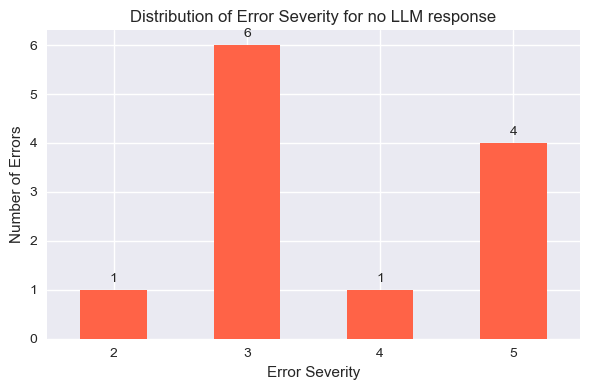

In [187]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
severity_counts.plot(kind='bar', color='tomato')
plt.xlabel('Error Severity')
plt.ylabel('Number of Errors')
plt.title('Distribution of Error Severity for no LLM response')
plt.xticks(rotation=0)
for idx, val in enumerate(severity_counts):
    plt.text(idx, val+0.1, int(val), ha='center', va='bottom')
plt.tight_layout()
plt.show()


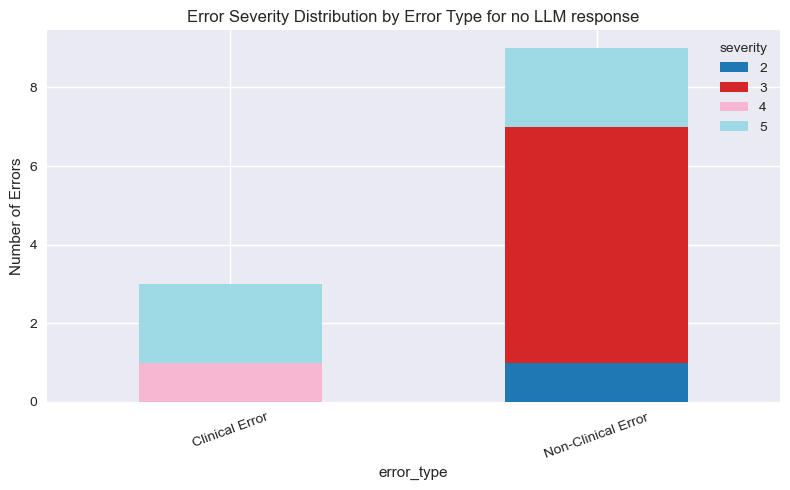

In [188]:
# Prepare a DataFrame for severity x error_type
error_type_sev = []
for _, row in no_LLM_response_df.iterrows():
    for et, sev in zip(row['error_types'], row['error_severities']):
        error_type_sev.append((et, sev))

err_df = pd.DataFrame(error_type_sev, columns=['error_type', 'severity'])
pivot = pd.crosstab(err_df['error_type'], err_df['severity']).sort_index(axis=1)

pivot.plot(kind='bar', stacked=True, figsize=(8,5), colormap='tab20')
plt.ylabel("Number of Errors")
plt.title("Error Severity Distribution by Error Type for no LLM response")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


## 2.1. How does the LLM score across key clinical communication criteria?

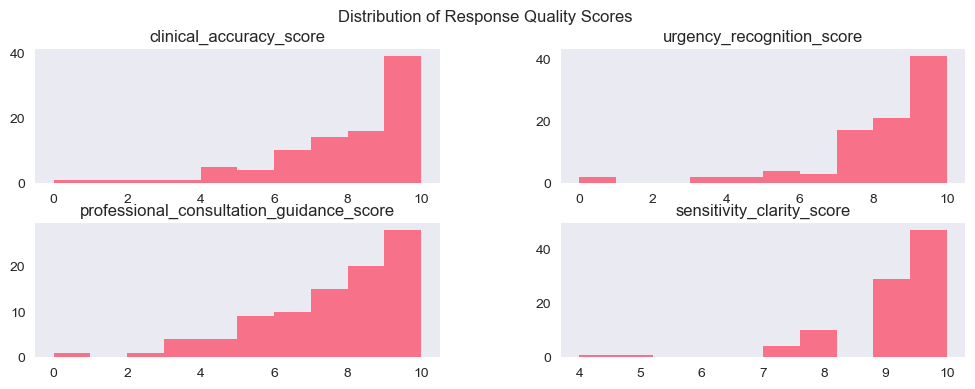

In [193]:
with_LLM_response_df[score_columns].hist(bins=10, figsize=(12,4), grid=False)
plt.suptitle("Distribution of Response Quality Scores")
plt.show()


## 2.2 Do responses with errors have lower scores?

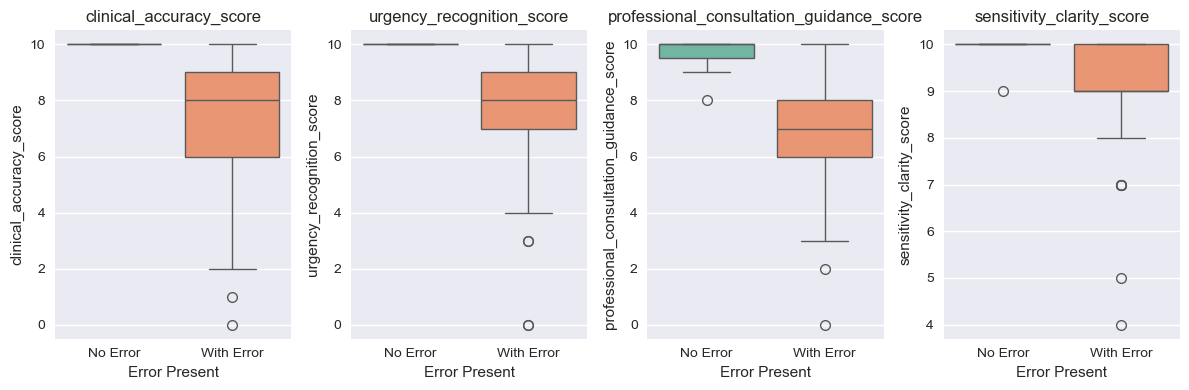

In [194]:
plt.figure(figsize=(12,4))
for i, col in enumerate(score_columns):
    plt.subplot(1, len(score_columns), i+1)
    sns.boxplot(x=with_LLM_response_df['has_error'], y=with_LLM_response_df[col], palette='Set2')
    plt.xticks([0,1], ['No Error', 'With Error'])
    plt.title(col)
    plt.xlabel("Error Present")
plt.tight_layout()
plt.show()


## 2.3 Are there patterns by message type?

In [197]:
mean_scores_by_type = with_LLM_response_df.groupby('type')[score_columns].mean().round(2)
mean_scores_by_type


,clinical_accuracy_score,urgency_recognition_score,professional_consultation_guidance_score,sensitivity_clarity_score
type,,,,
Administrative Request,7.75,7.88,7.00,9.12
Appointment Request,8.14,8.86,7.00,9.43
Clinical Advice Request,7.75,7.88,7.58,9.25
General Inquiry,10.00,10.00,10.00,10.00
Medication Request,7.76,7.95,7.00,9.38
Referral Request,6.85,6.85,6.08,8.23
Test Result Inquiry,7.56,8.83,7.78,9.61


In [267]:
with_LLM_response_df["type"].value_counts()


type
Clinical Advice Request    24
Medication Request         21
Test Result Inquiry        18
Referral Request           13
Administrative Request      8
Appointment Request         7
General Inquiry             1
Name: count, dtype: int64

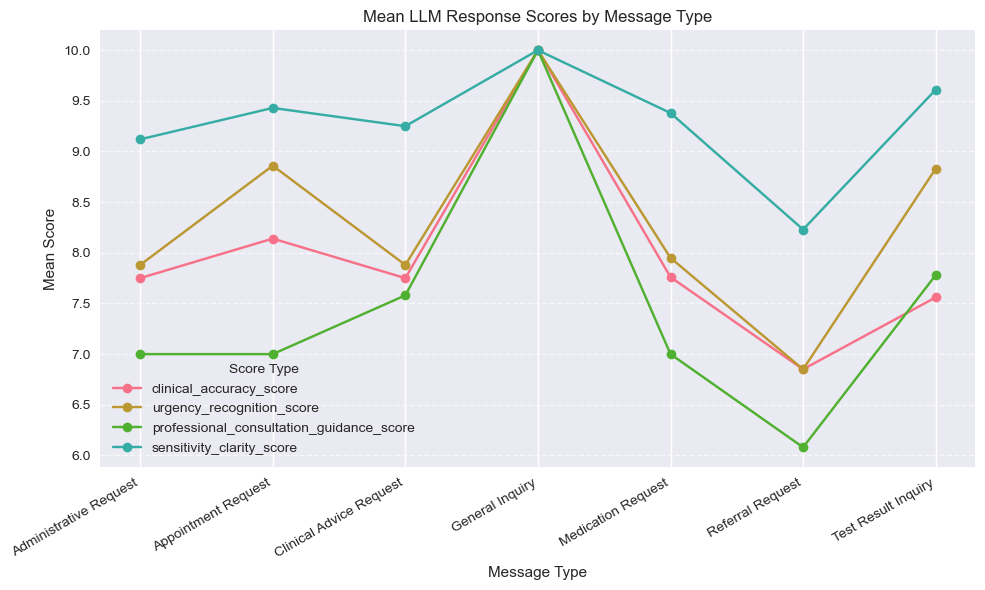

In [199]:
import matplotlib.pyplot as plt

# Make sure you have mean_scores_by_type computed:
# mean_scores_by_type = with_LLM_response_df.groupby('type')[score_columns].mean().round(2)

plt.figure(figsize=(10,6))

for col in mean_scores_by_type.columns:
    plt.plot(mean_scores_by_type.index, mean_scores_by_type[col], marker='o', label=col)

plt.xticks(rotation=30, ha='right')
plt.xlabel('Message Type')
plt.ylabel('Mean Score')
plt.title('Mean LLM Response Scores by Message Type')
plt.legend(title='Score Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 3.1 “Does the LLM make mistakes that physicians wouldn’t?”

In [214]:
unique_llm_error_count = sum(
    response == 'No'
    for row in with_LLM_response_df["error_in_physician_response"]
    for response in row
)
total_errors = with_LLM_response_df["num_errors"].sum()
unique_llm_error_pct = unique_llm_error_count / total_errors * 100
print(f"LLM made {unique_llm_error_count} errors ({unique_llm_error_pct:.1f}%) not found in physician responses.")


LLM made 94 errors (78.3%) not found in physician responses.


In [251]:
with_LLM_response_df['shared_error'] = with_LLM_response_df["error_in_physician_response"].apply(lambda lst: 'Yes' in lst)
shared_errors_df = with_LLM_response_df[with_LLM_response_df['shared_error'] == True]
print(f"Number of responses with shared errors: {len(shared_errors_df)}")


Number of responses with shared errors: 19


In [205]:
from collections import Counter
import pandas as pd

# Flatten error_types and error_severities for shared errors
shared_error_types = [et for row in shared_errors_df['error_types'] for et in row]
shared_severities = [sev for row in shared_errors_df['error_severities'] for sev in row]

# Counts by error type and severity
error_type_counts = pd.Series(Counter(shared_error_types))
severity_counts = pd.Series(Counter(shared_severities)).sort_index()

print("Shared error type counts:\n", error_type_counts)
print("\nShared severity distribution:\n", severity_counts)


Shared error type counts:
 Non-Clinical Error    10
Clinical Error        18
dtype: int64

Shared severity distribution:
 1     4
2    15
3     8
4     1
dtype: int64


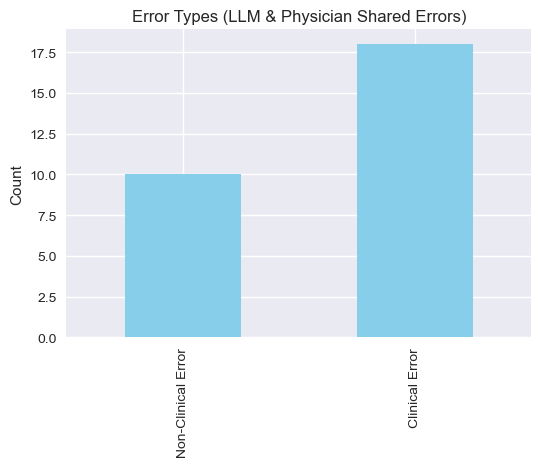

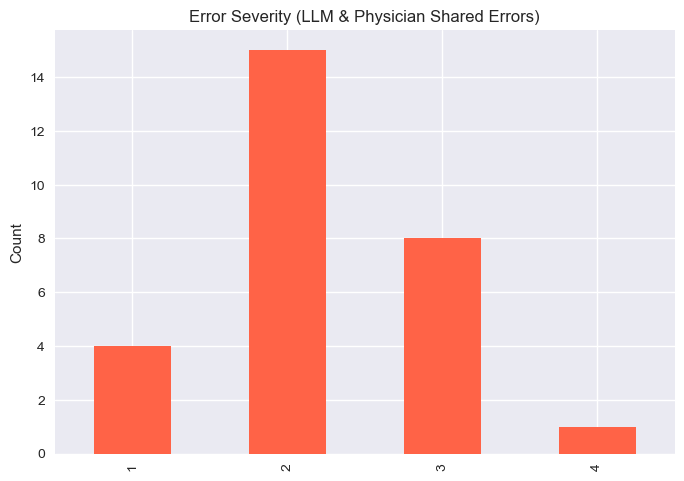

In [206]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
error_type_counts.plot(kind='bar', color='skyblue')
plt.title("Error Types (LLM & Physician Shared Errors)")
plt.ylabel("Count")
plt.show()

severity_counts.plot(kind='bar', color='tomato')
plt.title("Error Severity (LLM & Physician Shared Errors)")
plt.ylabel("Count")
plt.show()


## 4.1 Are certain message types more error-prone?

In [209]:
# For all errors (not just shared):
type_error_rate = with_LLM_response_df.groupby('type')['has_error'].mean().sort_values(ascending=False)
print("Error rate by message type:\n", type_error_rate)

# For shared errors only (i.e., error also present in physician):
type_shared_error_rate = with_LLM_response_df.groupby('type')['shared_error'].mean().sort_values(ascending=False)
print("\nShared error rate by message type:\n", type_shared_error_rate)


Error rate by message type:
 type
Referral Request           1.000000
Test Result Inquiry        0.888889
Administrative Request     0.875000
Clinical Advice Request    0.875000
Appointment Request        0.857143
Medication Request         0.857143
General Inquiry            0.000000
Name: has_error, dtype: float64

Shared error rate by message type:
 type
Medication Request         0.285714
Administrative Request     0.250000
Test Result Inquiry        0.222222
Clinical Advice Request    0.208333
Appointment Request        0.142857
Referral Request           0.076923
General Inquiry            0.000000
Name: shared_error, dtype: float64


## 4.2. Which message categories are “safe” for LLMs, and which are risky?


In [210]:
# Average error severity per type
type_avg_severity = with_LLM_response_df.groupby('type')['avg_error_severity'].mean().sort_values(ascending=False)
print("\nAverage error severity by message type:\n", type_avg_severity)



Average error severity by message type:
 type
Referral Request           2.602564
Administrative Request     2.250000
Test Result Inquiry        2.212963
Appointment Request        2.166667
Medication Request         2.142857
Clinical Advice Request    2.076389
General Inquiry            0.000000
Name: avg_error_severity, dtype: float64


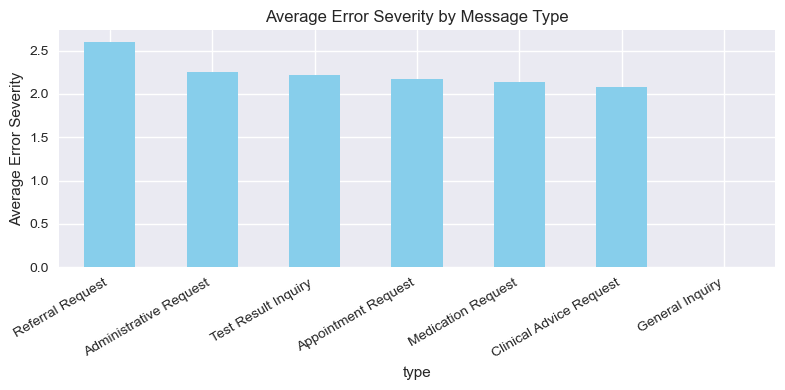

In [211]:
plt.figure(figsize=(8,4))
type_avg_severity.plot(kind='bar', color='skyblue')
plt.ylabel("Average Error Severity")
plt.title("Average Error Severity by Message Type")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


## 5.1 Case Study

### a. No Error

In [233]:
### a. No Error
raw_message_26 = raw_data.loc[26]
print(raw_message_26["Patient Message"].replace("<10>", "\n"))


hi can you call in my estring prescription renewal?thanks!


In [234]:
print(raw_message_26["Actual Response Sent to Patient"])

Hello,Your prescription has been approved and sent to the pharmacy.Take care 


In [235]:
print(raw_message_26["Suggested Response from LLM"])

Hi Mia,<10><10>I will reorder your Estring prescription and send it to Amazon Pharmacy Home Delivery in Austin, TX. It will be available once processed by the pharmacy.<10><10>Take care!


In [269]:
with_LLM_response_df.loc[26]

row_number                                                                                   0026
file_path                                       ../error_checking/automated_outputs/evaluator_...
subject                                                                  Visit Follow-up Question
type                                                                           Medication Request
reasoning                                       The patient's message is a straightforward req...
clinical_accuracy_score                                                                        10
clinical_accuracy_reasoning                     The response confirms the prescription renewal...
urgency_recognition_score                                                                      10
urgency_recognition_reasoning                   The request is not urgent. The response correc...
professional_consultation_guidance_score                                                       10
professional_consult

### b. High scoring with a minor error

In [220]:
raw_message_57 = raw_data.loc[57]
print(raw_message_57["Patient Message"].replace("<10>", "\n"))

I received a text message from Lilly Direct about the prescription placed yesterday and this is what it said:The prescription we received from your physician cannot yet be processed due to invalid or missing information. We have notified your physician of the issues and what information to correct. We will contact you as soon as we receive an updated prescription. You may also reach out to your physician directly. Here are the reasons for the rejection:- The prescribed medication or form is invalid


In [224]:
print(raw_message["Actual Response Sent to Patient"])

Hello Morgan S Stacey,My name is Stephanie , MA and I work closely with your primary care provider as a medical assistant. Thank you. We did receive the form and have Dr.Khuddus review it. Thank you for your time,Stephanie Hernandez , MA Please note: It may take up to 48 hours to respond to your myhealth message. If you have any urgent concerns, please call. Calls/Messages sent after 5pm will not be addressed until the following business day. Office Hours: Monday - Friday 8:00am - 5:00pm. Saturday/Sunday: CLOSED


In [225]:
print(raw_message["Suggested Response from LLM"])

Thank you for letting me know, Morgan. I will review the prescription details and correct any issues. Once updated, the prescription will be resent to Lilly Direct. I appreciate your patience.


In [226]:
sample_57 = with_LLM_response_df[with_LLM_response_df["avg_error_severity"] < 2].loc[57]

In [229]:
sample_57

row_number                                                                                   0057
file_path                                       ../error_checking/automated_outputs/evaluator_...
subject                                                                     Prescription Question
type                                                                           Medication Request
reasoning                                       The patient is inquiring about an issue with a...
clinical_accuracy_score                                                                         9
clinical_accuracy_reasoning                     The LLM response appropriately acknowledges th...
urgency_recognition_score                                                                       7
urgency_recognition_reasoning                   The response recognizes that a correction is n...
professional_consultation_guidance_score                                                        7
professional_consult

In [231]:
sample_57["error_descriptions"] # i think second question might make sense

['Lack of timeframe or instructions for urgent needs. The response does not specify how long the correction will take, or what to do if the patient needs the medication urgently.',
 'Does not restate medication name or specific issue as reported by patient, which could lead to minor confusion.']

### c. Md scoring with a moderate error

In [237]:
sample_63 = with_LLM_response_df[with_LLM_response_df["avg_error_severity"] ==3].loc[63]

In [239]:
raw_message_63 = raw_data.loc[63]
print(raw_message_63["Patient Message"].replace("<10>", "\n"))
print(raw_message_63["Actual Response Sent to Patient"])
print(raw_message_63["Suggested Response from LLM"])

Hi Zhi: Since my appointment two weeks ago I went off the amlodipine to see my BP levels unmedicated. The last date I took the amlodipine 10 mg was 11/20, and since then I've taken my BP right after I wake up and then again in the afternoon or evening. In the two weeks my BP is typically ~135/88. A few times the systolic was above 140 (but not above 145), and would typically be under that threshold when I took it again a minute later. More commonly the diastolic was the one out of the desired range (but not above 93) but that too would come down. Do you think I still need medication and should start the Micardis you prescribed?
Hi Haley,Thanks for the update. It sounds like your blood pressures are at the borderline level between lifestyle modification or medication. There is a debate of blood pressure goal of <140/90 for in-office readings or <135/85 for at home readings. It would be based off your preference at this point and we can revisit annually.It's interesting that you were on 

In [241]:
sample_63

row_number                                                                                   0063
file_path                                       ../error_checking/automated_outputs/evaluator_...
subject                                                                  Visit Follow-up Question
type                                                                      Clinical Advice Request
reasoning                                       The patient is requesting advice regarding whe...
clinical_accuracy_score                                                                         6
clinical_accuracy_reasoning                     The response correctly notes that BP is elevat...
urgency_recognition_score                                                                       8
urgency_recognition_reasoning                   The reply appropriately does not suggest urgen...
professional_consultation_guidance_score                                                        6
professional_consult

In [242]:
sample_63["clinical_accuracy_reasoning"]

"The response correctly notes that BP is elevated and recommends starting telmisartan as prescribed, which is reasonable given the patient's history and readings. However, it oversimplifies management, omitting shared decision-making regarding medication initiation, discussion of BP goals, the appropriateness of dose, or consideration of lifestyle management versus immediate medication restart. It does not comment on possible dose adjustment despite readings being borderline, nor on the potential renal-protective rationale. Thus, it's somewhat incomplete."

### d. Low-scoring with severe error

In [244]:
raw_message_30 = raw_data.loc[30]
print(raw_message_30["Patient Message"].replace("<10>", "\n"))
print(raw_message_30["Actual Response Sent to Patient"])
print(raw_message_30["Suggested Response from LLM"])
sample_30 = with_LLM_response_df[with_LLM_response_df["avg_error_severity"] > 3].loc[30]
sample_30
sample_30["error_descriptions"]

Hi Dr. Tim, I hope you are doing well. I received a text message from Quest that said “Your healthcare provider ordered  your testing.” Is this true. My next appointment with you is June 3, 2025. Kind regards,Diana Kay
Hello Diana, this is Julia Fellows PA-C responding to your message on behalf of your primary care provider. I am helping Dr. Tim with her messages today.I see that Dr. Dolezol may have sent some orders to Quest yesterday, but then changed it to the Emeryville lab. That is probably why you got a notification from Quest. I do not see anything ordered by Dr. Tim at this time. No need for you to do anything on your end!Julia Fellows 
Hi Diana,<10><10>Yes, that is correct. I have ordered your blood work to be done at Quest Lab in 6 months. Please make sure to fast for at least 8-10 hours prior to your appointment (water is okay). <10><10>If you have any other questions or concerns, feel free to reach out.<10><10>Kind regards,


['Incorrectly confirms that a blood work order at Quest in 6 months is active; encourages unnecessary fasting and gives misleading instructions when the order may not exist or may be set for a different lab.']

In [243]:
with_LLM_response_df[with_LLM_response_df["avg_error_severity"] > 3]

,row_number,file_path,subject,type,reasoning,clinical_accuracy_score,clinical_accuracy_reasoning,urgency_recognition_score,urgency_recognition_reasoning,professional_consultation_guidance_score,...,error_types,error_severities,error_descriptions,error_text_excerpts,error_in_physician_response,reason_for_error_in_physician_response,has_error,avg_error_severity,has_LLM_response,shared_error
8,0008,../error_checking/automated_outputs/evaluator_...,Prescription Question,Medication Request,The patient's message is primarily a request f...,4,The LLM-generated response agrees to prescribe...,5,The response acknowledges flu symptoms and kno...,3,...,"[Clinical Error, Clinical Error]","[4, 3]",[Tamiflu was prescribed without prior clinical...,[I will send the prescription to the CVS pharm...,"[Yes, Yes]",[Given that your wife has been diagnosed with ...,True,3.5,True,True
29,0029,../error_checking/automated_outputs/evaluator_...,Non-urgent Medical Question,Referral Request,The patient's message explicitly requests a re...,0,The LLM-generated response does not address th...,0,The response fails to recognize or address the...,0,...,[Clinical Error],[4],[Omission of response to the patient's direct ...,"[You're welcome, Kashifa! If you have any furt...",[No],"[Hi Kashifa,Thank you for reaching out. Sex th...",True,4.0,True,False
30,0030,../error_checking/automated_outputs/evaluator_...,Ordered Test Question,Test Result Inquiry,The patient's message asks whether a test orde...,2,The LLM response incorrectly affirms that a bl...,5,The response treats the inquiry as routine and...,3,...,[Clinical Error],[4],[Incorrectly confirms that a blood work order ...,"[Yes, that is correct. I have ordered your blo...",[No],[I do not see anything ordered by Dr. Tim at t...,True,4.0,True,False
34,0034,../error_checking/automated_outputs/evaluator_...,Update Health Information,Clinical Advice Request,The patient is asking if her prior cardiac Hol...,1,The response does not address any of the patie...,0,Potentially urgent concerns about cardiovascul...,2,...,"[Clinical Error, Non-Clinical Error]","[4, 3]",[Completely fails to address the patient's cli...,[Thank you for letting me know. Please feel fr...,"[No, No]",[The physician response proactively arranges a...,True,3.5,True,False


### e. shared errors

In [249]:
raw_message_8 = raw_data.loc[8]
print(raw_message_8["Patient Message"].replace("<10>", "\n"))
print(raw_message_8["Actual Response Sent to Patient"])
print(raw_message_8["Suggested Response from LLM"])
sample_8 = shared_errors_df[shared_errors_df["avg_error_severity"] > 3].loc[8]
sample_8["error_descriptions"]

Hello Doctor,           I am having flu like symptoms. My wife diagnosed with Influenza A. And she is taking Tamiflu. So wondering if it is possible to prescribe it for me on the CVS pharmacy on the file. Please let me know.Thanks,Keshav 
Hello Keshav,I'm sorry to hear that you are experiencing flu-like symptoms. Given that your wife has been diagnosed with Influenza A and you are showing similar symptoms, it would be reasonable to start Tamiflu. I will send the prescription to the CVS pharmacy on file for you.If your symptoms worsen or you have any concerns, please don't hesitate to reach out or schedule an appointment through the Stanford MyHealth app.Take care and feel better soon.Jesse Amanda Rokicki Parashar, MD
Hello Keshav,<10><10>I'm sorry to hear that you are experiencing flu-like symptoms. Given that your wife has been diagnosed with Influenza A and you are showing similar symptoms, it would be reasonable to start Tamiflu. I will send the prescription to the CVS pharmacy on f

['Tamiflu was prescribed without prior clinical assessment or confirmation of timing of symptom onset, contrary to standard practice and safety protocol.',
 'The response does not include appropriate safety netting for severe symptoms (e.g., chest pain, difficulty breathing, high fever, or inability to keep down fluids), potentially delaying recognition of serious illness.']

In [270]:
shared_errors_df.loc[8]

row_number                                                                                   0008
file_path                                       ../error_checking/automated_outputs/evaluator_...
subject                                                                     Prescription Question
type                                                                           Medication Request
reasoning                                       The patient's message is primarily a request f...
clinical_accuracy_score                                                                         4
clinical_accuracy_reasoning                     The LLM-generated response agrees to prescribe...
urgency_recognition_score                                                                       5
urgency_recognition_reasoning                   The response acknowledges flu symptoms and kno...
professional_consultation_guidance_score                                                        3
professional_consult

In [260]:
shared_errors_df[shared_errors_df["avg_error_severity"] == 3]

,row_number,file_path,subject,type,reasoning,clinical_accuracy_score,clinical_accuracy_reasoning,urgency_recognition_score,urgency_recognition_reasoning,professional_consultation_guidance_score,...,error_types,error_severities,error_descriptions,error_text_excerpts,error_in_physician_response,reason_for_error_in_physician_response,has_error,avg_error_severity,has_LLM_response,shared_error
20,0020,../error_checking/automated_outputs/evaluator_...,Prescription Question,Medication Request,The patient is asking about adjustment of her ...,6,The response appropriately assesses the patien...,10,The LLM recognizes that the patient is current...,7,...,[Clinical Error],[3],[Prescribing hydroxyzine as a safety medicatio...,"[Regarding the hydroxyzine tablet, I will pres...",[Yes],"[At this time, I am not able to prescribe hydr...",True,3.0,True,True
25,0025,../error_checking/automated_outputs/evaluator_...,Visit Follow-up Question,Administrative Request,The patient is requesting support in having a ...,7,The LLM response offers to facilitate the re-s...,10,"The LLM correctly treats this as a non-urgent,...",7,...,[Non-Clinical Error],[3],[Incorrectly states the provider's office can ...,[I will contact Dr. Sun’s office to have the q...,[Yes],"[Unfortunately, we do not handle any pre scree...",True,3.0,True,True
51,0051,../error_checking/automated_outputs/evaluator_...,Non-urgent Medical Question,Appointment Request,The message is from a guardian requesting avai...,10,The response gives accurate instructions on ho...,10,The message is handled appropriately as a rout...,8,...,[Non-Clinical Error],[3],[Omission of tailored appointment guidance and...,[please use the Stanford MyHealth app to view ...,[Yes],[Are you available for a visit on a Friday aft...,True,3.0,True,True
66,0066,../error_checking/automated_outputs/evaluator_...,Prescription Question,Medication Request,The patient's message is specifically requesti...,10,The LLM's response accurately confirms the req...,6,The response completes the requested action bu...,7,...,[Non-Clinical Error],[3],[Omission of information about what to do if t...,[It should be available once processed by the ...,[Yes],"[Reminder:For urgent issues, call 650-498-9000...",True,3.0,True,True
72,0072,../error_checking/automated_outputs/evaluator_...,Prescription Question,Medication Request,The patient's message is about being out of Am...,10,The response correctly addresses the medicatio...,7,The response addresses the issue efficiently a...,7,...,[Clinical Error],[3],[Does not acknowledge potential clinical conce...,[I will reorder the medication for you and sen...,[Yes],[The actual physician response also does not e...,True,3.0,True,True


In [264]:
shared_errors_df[shared_errors_df["avg_error_severity"] == 3].loc[25]
raw_message_25 = raw_data.loc[25]
print(raw_message_25["Patient Message"].replace("<10>", "\n"))
print(raw_message_25["Actual Response Sent to Patient"])
print(raw_message_25["Suggested Response from LLM"])
sample_25 = shared_errors_df[shared_errors_df["avg_error_severity"] == 3].loc[25]
sample_25["error_descriptions"]

Good morning, Dr.  Baule,Hope you had a nice Thanksgiving. At our last appointment, we discussed scheduling a colonoscopy. I received a questionnaire, from Dr. Sun’s office, however, it expired and I’m unable to complete the pre screening process. Can the questionnaire, be resent. Thank you,Marco 
Hi Marco,Unfortunately, we do not handle any pre screening questionnaires that are sent by Dr. Sun's office. Please give them a call in regards to the questionnaire, if they are able to resend it or maybe do it over the phone with you. Let us know. Thank you.Best,Family Medicine Samaritan Los GatosPlease note: It may take up to 48 hours to respond to your myhealth message. If you have any urgent concerns, please call. Calls/Messages sent after 5pm will not be addressed until the following business day. Office Hours: Monday - Friday 8:00am - 5:00pm. Saturday/Sunday: CLOSED
Good morning, Marco,<10><10>I hope you had a nice Thanksgiving as well.<10><10>I will contact Dr. Sun’s office to have the

["Incorrectly states the provider's office can contact Dr. Sun's office and have the questionnaire resent, which does not align with actual office workflow."]